## Understanding how the environment works


In [1]:
import os, sys
import gymnasium as gym
import time

import text_flappy_bird_gym

if __name__ == "__main__":
    # initiate environment
    env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)
    obs = env.reset()

    # iterate
    while True:
        # Select next action
        action = (
            env.action_space.sample()
        )  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2)  # FPS

        # If player is dead break
        if done:
            break

    env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=3)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=5)
Text Flappy Bird!
Score: 0
----------------------
[       

In [2]:
import scipy
import numpy as np


# Ausiliary function
def discount_cumsum(x, discount):
    """
    magic for computing discounted cumulative sums of vectors.
    input:
        vector x,
        [x0,
         x1,
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

## Implement first-visit on-policy MC Control


In [9]:
class MC_Control:
    def __init__(self, space_size, action_size, gamma=1):
        """
        Calculates optimal policy using first visit on-policy Monte Carlo control
        Evaluates Q-value for (S,A) pairs.
        """
        # discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size  # as tuple # sarebbe il self.size della classe di smash per MC lab 3
        self.action_size = action_size

        # where to save returns
        self.returns = [
            [[[] for _ in range(2)] for _ in range(observation_space[0])]
            for _ in range(observation_space[1])
        ]

        # where to save Qvalues
        self.Qvalues = np.zeros((*self.space_size, self.action_size))

        # just fper esser piu veloce a runnare
        self.ones = np.ones(self.action_size)

    def get_action_epsilon_greedy(self, s, eps):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        ran = np.random.rand()

        if ran < eps:
            # probability is uniform for all actions!
            prob_actions = self.ones / self.action_size

        else:
            # I find the best Qvalue
            best_value = np.max(self.Qvalues[(*s,)])

            # There could be actions with equal value!
            best_actions = self.Qvalues[(*s,)] == best_value

            # best_actions is
            # *True* if the value is equal to the best (possibly ties)
            # *False* if the action is suboptimal
            prob_actions = best_actions / np.sum(best_actions)

        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a

    def greedy_policy(self):
        # CODE HERE!

        a = np.argmax(self.Qvalues, axis=2)
        return a

    # -------------------
    def single_episode_update(self, traj_states, traj_rew, traj_act):
        """
        Uses a single trajectory to update the Qvalues, using first-visit MC.
        """
        # keep track of visited pair (state, action)
        visited_pairs = []
        remaining_pairs = [(traj_states[t], traj_act[t]) for t in range(len(traj_act))]

        # calculates the returns for each step: DISCOUNTed CUMulative SUM.
        ret = discount_cumsum(traj_rew, self.gamma)

        # given teh current episode, take the last pair (St, At) and go backward
        for t_step, s in reversed(list(enumerate(traj_states))):
            # get the action taken after being in state s
            action = traj_act[t_step]

            # build the pair (St, At) = ((x,y), At)
            pair = (s, action)

            remaining_pairs.pop()

            if pair in remaining_pairs:
                # print("pair: ", pair)
                s = pair[0]
                action = pair[1]
                # print(s)

                self.returns[s[0]][s[1]][action].append(ret[t_step])
            else:
                self.returns[s[0]][s[1]][action].append(ret[t_step])
                visited_pairs.append((s, action))

        for pair in visited_pairs:
            s = pair[0]
            action = pair[1]
            self.Qvalues[s[0]][s[1]][action] = np.mean(self.returns[s[0]][s[1]][action])

        return self.Qvalues

In [10]:
n_episodes = 20000
Actions = [0, 1]  # flap / no flap
observation_space = (env.observation_space[0].n, env.observation_space[1].n)
observation_space

(14, 22)

In [11]:
# Initialize
MC = MC_Control(space_size=observation_space, action_size=2, gamma=1)
epsilon_0 = 0.2

performance_traj_MC = np.zeros(
    n_episodes
)  # performance trajctories stores the total rewards for each episode


count = 0
tstar = 50000
epsilon = epsilon_0

# RUN OVER EPISODES
for i in range(n_episodes):
    traj_states = []
    traj_rew = []
    traj_act = []
    done = False

    s, info = env.reset()
    a = MC.get_action_epsilon_greedy(s=s, eps=epsilon)
    act = Actions[a]

    while not done:
        count += 1

        new_s, r, done, _, info = env.step(act)
        traj_states.append(s)
        traj_act.append(a)
        traj_rew.append(r)

        # Keeps track of performance for each episode
        performance_traj_MC[i] += r

        # Choose new action index
        new_a = MC.get_action_epsilon_greedy(new_s, epsilon)

        # (Corresponding action to index)
        act = Actions[new_a]
        a = new_a
        s = new_s

        if count > tstar:
            # UPDATE OF LEARNING

            # UPDATE OF EPSILON
            epsilon = epsilon_0 / (1.0 + 0.005 * (count - tstar) ** 1.05)

    # MC step at the end of the episode (averaging)
    MC.Qvalues = MC.single_episode_update(traj_states, traj_rew, traj_act)


Qvalues = MC.Qvalues

In [13]:
plot_indexes = np.arange(
    0, n_episodes + 1, 20, dtype=int
)  # Only plot a sub-plot of results
plot_indexes[-1] = plot_indexes[-1] - 1

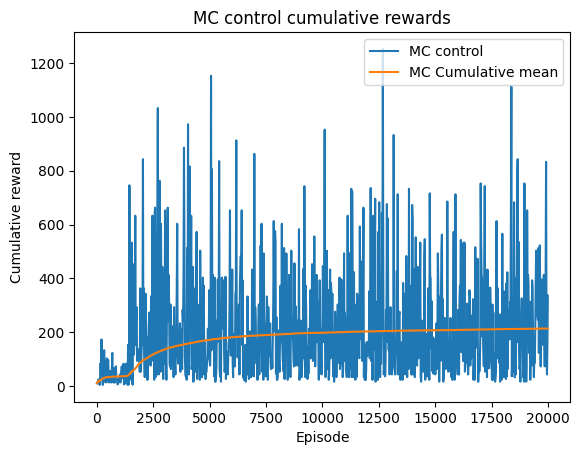

In [14]:
import matplotlib.pyplot as plt

cumulative_mean_MC = np.cumsum(performance_traj_MC) / np.arange(
    1, len(performance_traj_MC) + 1
)

plt.plot(plot_indexes, performance_traj_MC[plot_indexes], label="MC control")
plt.plot(plot_indexes, cumulative_mean_MC[plot_indexes], label="MC Cumulative mean")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.legend()
plt.title("MC control cumulative rewards")
plt.savefig("MC_control_epsilon_decay.png")